In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
import random

In [ ]:
class RRTConnect:
    def __init__(self, start_node: np.ndarray, end_node: np.ndarray, obstacles: np.ndarray, map_size, step_size=0.5, max_iter=2000):
        self.start = start_node
        self.goal = end_node
        self.obstacles = obstacles
        self.map_size = map_size
        self.step_size = step_size
        self.max_iter = max_iter

        self.node_list = np.zeros((max_iter, 4))
        self.node_list[0] = self.start

        self.enode_list = np.zeros((max_iter, 4))
        self.enode_list[0] = self.goal

        self.connect_region_radius = 1.5
        self.search_radius = 2.0
        self.path = None
        self.goal_reached = False

        # Visualization setup
        self.fig, self.ax = plt.subplots()
        self.setup_visualization()

    def setup_visualization(self):
        """Set up the visualization environment (grid, start, goal, obstacles)."""
        self.ax.plot(self.start[0], self.start[1], 'bo', label='Start')
        self.ax.plot(self.goal[0], self.goal[1], 'go', label='Goal')
        self.ax.set_xlim(0, self.map_size[0])
        self.ax.set_ylim(0, self.map_size[1])
        self.ax.grid(True)

        # Draw the randomly generated obstacles
        self.draw_obstacles()

    def draw_obstacles(self):
        """Draw the static obstacles on the map."""
        for row in self.obstacles:
            circle = plt.Circle((row[0], row[1]), row[2], color='r')
            self.ax.add_artist(circle)

    def plan_rrt(self):
        for i in range(1, self.max_iter):
            rand_node = self.get_random_node(self.goal)
            nearest_node_index = self.get_nearest_node_index(i, rand_node, self.node_list[:i])
            new_node = self.steer(nearest_node_index, rand_node)

            rand_enode = self.get_random_node(self.start)
            nearest_enode_index = self.get_nearest_enode_index(i, rand_enode, self.enode_list[:i])
            new_enode = self.steer(nearest_enode_index, rand_enode)

            if self.is_collision_free(new_node):
                self.node_list[i] = new_node

                if self.reached_goal(new_node):
                    self.goal[2] = i
                    self.goal_reached = True
                    self.generate_path()
                    return self.goal_reached
                
            if self.is_collision_free(new_enode):
                self.enode_list[i] = new_enode

    def get_random_node(self, bias_node):
        """Generate a random node in the map."""
        if random.random() > 0.2: rand_node = [np.random.uniform(0, self.map_size[0]), np.random.uniform(0, self.map_size[1]), -1, 0]
        else: rand_node = bias_node.copy()
        return rand_node
    
    def get_nearest_node_index(self, i, rand_node, nodes):
        """Returns index of the nearest node"""
        distances = np.zeros(len(nodes))
        for i in range(len(nodes)):
            nodexy = nodes[i][:2]
            randxy = rand_node[:2]
            distances[i] = np.linalg.norm(nodexy-randxy)
        nearest_node_index = np.argmin(distances)
        return nearest_node_index

    def steer(self, nearest_node_index, rand_node):
        nearest_node = self.node_list[nearest_node_index]
        nodexy = nearest_node[:2]
        randxy = rand_node[:2]
        diff = randxy-nodexy
        ang = np.atan2(diff[1], diff[0])
        new_node = np.array([nodexy[0]+self.step_size*np.cos(ang),
                             nodexy[1]+self.step_size*np.sin(ang),
                             nearest_node_index,
                             0])
        cost = nearest_node[3] + np.linalg.norm(new_node[:2] - nodexy)
        new_node[3] = cost
        return new_node
    
    def is_collision_free(self, node):
        for obstacle in self.obstacles:
            detector = (node[0] - obstacle[0])**2 + (node[1] - obstacle[1])**2 <= obstacle[2]**2
            if(detector): return False
        return True
    
    def reached_goal(self, node):
        goalxy = self.goal[:2]
        nodexy = node[:2]
        dist_goal = np.linalg.norm(goalxy-nodexy)
        return dist_goal <= self.goal_region_radius
    
    def generate_path(self):
        self.path = []
        curr_node = self.goal
        while curr_node[2] != -1:
            self.path.append(curr_node)
            next_index = int(curr_node[2])
            curr_node = self.node_list[next_index]
        self.path = np.flip(self.path, 0)

    def plot_path(self):
        for i in range(1, len(self.path)):
            node_parent = self.path[i-1]
            node = self.path[i]
            self.ax.plot([node[0], node_parent[0]], [node[1], node_parent[1]], "-g")

    def plot_tree(self):
        num_expanded = self.goal[2]
        for i in range(1, num_expanded):
            node_parent = self.node_list[int(self.node_list[i, 2])]
            node = self.node_list[i]
            self.ax.plot([node[0], node_parent[0]], [node[1], node_parent[1]], "-b")

In [68]:
def generate_random_obstacles(map_size, num_obstacles):
    obstacles = np.zeros((num_obstacles, 3))
    for i in range(num_obstacles):
        ox = np.random.uniform(2, map_size[0] - 3)
        oy = np.random.uniform(2, map_size[1] - 3)
        size = np.random.uniform(1, 3)
        obstacles[i] = [ox, oy, size]
    return obstacles

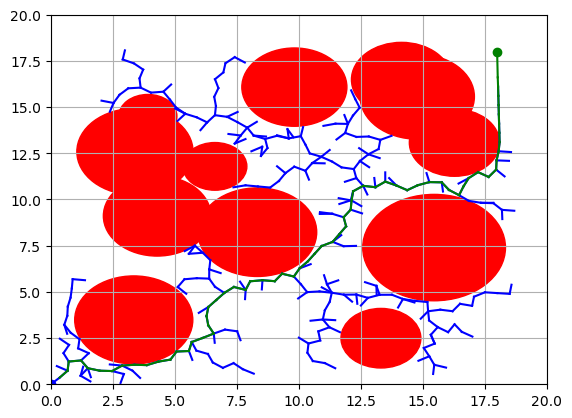

In [ ]:
start_node = np.array([0, 0, -1, 0]) # nodes structured [x, y, parent, cost]
end_node = np.array([18, 18, -1, 0])
map_size = [20, 20]
obstacles = generate_random_obstacles(map_size, 12)
planner = RRTConnect(start_node=start_node, end_node=end_node, obstacles=obstacles, map_size=map_size)
planner.plan_rrt()
planner.plot_tree()
planner.plot_path()